# Confidence of interval for $\langle x^2 \rangle $ i.e non central $\chi^2$

- T tirages de Nobs colocations $X_i$
- $X_i$ suivent loi normale avec N-1 degree de liberté, std $\sigma$ et moyenne $\mu$ même pour tous (discutable std et moyenne différentes sur l'ensemble des océans)

Alors $\sum_0^{N-1}(\frac{X_i}{\sigma})^2 \sim \frac{(N-1)}{\sigma^2}\langle X_i^2 \rangle$ suit une loi $\chi^2$ non centrée

https://fr.wikipedia.org/wiki/Loi_du_χ²_non_centrée
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ncx2.html

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
from histlib.cstes import zarr_dir

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
Nobs = 1000
T = 500000
mean = 1
std = 1
alpha = 0.01

from scipy.stats import ncx2
df = Nobs-1 # degree of freedom
nc = df * (mean/std)**2 #non-centrality parameter

x = xr.DataArray(np.random.normal(mean, std, (Nobs,T)),
                 dims=["Nobs", "T"],
                 coords=dict(Nobs=(["Nobs"], np.arange(Nobs)),T=(['T'], np.arange(T))))
x2n = df*(x/std)**2
x2 =x**2

x2_true = std**2+mean**2

## Vérification loi :

Text(0.5, 0, '$\\frac{(N-1)}{\\sigma^2}\\langle x^2 \\rangle$')

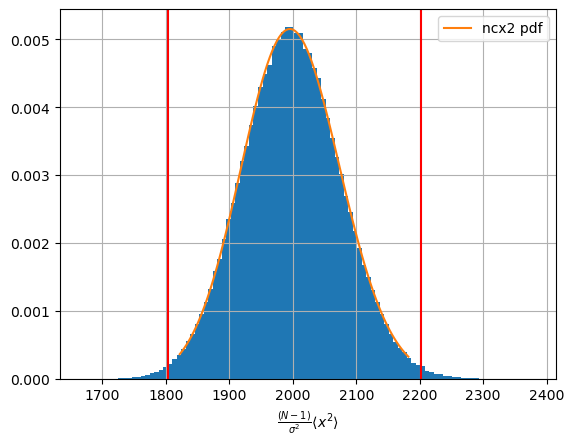

In [3]:
a = x2n.mean(dim='Nobs').plot.hist(bins =100, density=True)
rv = ncx2(df, nc)
x_ = np.linspace(ncx2.ppf(0.01, df, nc),ncx2.ppf(0.99, df, nc), 100)
plt.axvline(ncx2.ppf(alpha/2, df, nc), color='r')
plt.axvline(ncx2.ppf(1-alpha/2, df, nc), color='r')
plt.plot(x_, ncx2.pdf(x_, df, nc), label='ncx2 pdf')
plt.legend()
plt.grid()
plt.xlabel(r'$\frac{(N-1)}{\sigma^2}\langle x^2 \rangle$')

Text(0.5, 0, '$\\langle x^2 \\rangle$')

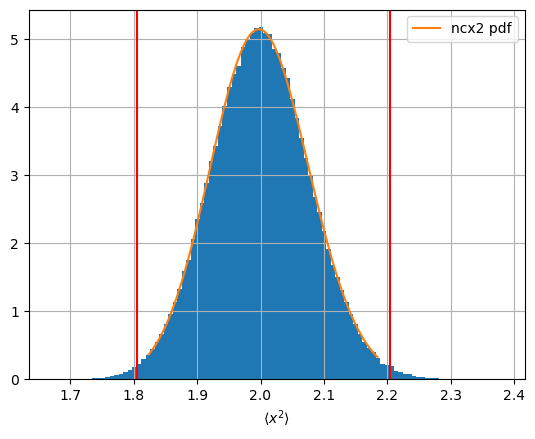

In [4]:
norm = df/(std**2)

a = x2.mean(dim='Nobs').plot.hist(bins =100,density=True)
rv = ncx2(df, nc)
x_ = np.linspace(ncx2.ppf(0.01, df, nc),ncx2.ppf(0.99, df, nc), 100)
plt.axvline(ncx2.ppf(alpha/2, df, nc)/norm, color='r')
plt.axvline(ncx2.ppf(1-alpha/2, df, nc)/norm, color='red')
plt.plot(x_/norm, ncx2.pdf(x_, df, nc)*norm, label='ncx2 pdf')
plt.grid()
plt.legend()
plt.xlabel(r'$\langle x^2 \rangle$')

# Confidence interval

- cf p219 Data analysis methods in Physical Oceanography, just changing central $\chi^2$ with non central one:
The well known $100(1-\alpha)\%$ interval for the true mean square value $\langle X_i^2\rangle$ when sampled from a normal population is :
$$ \frac{(N-1)s^2}{\chi^2_{\alpha/2, N-1, \lambda}}<\langle X_i^2 \rangle< \frac{(N-1)s^2}{\chi^2_{1-\alpha/2, N-1, \lambda}}$$
where $s$ is the estimated std, and the excentricity $\lambda = \sum_0^{N-1}(\frac{\mu}{\sigma})^2$

In [47]:
def get_xlow(x, df, alpha):
    nc = df*(x.mean(axis=-1)/x.std(axis=-1))**2
    norm = df/(x.std(axis=-1)**2)
    return ncx2.ppf(alpha/2, df, nc)/norm

def get_xup(x, df, alpha):
    nc = df*(x.mean(axis=-1)/x.std(axis=-1))**2
    norm = df/(x.std(axis=-1)**2)
    return ncx2.ppf(1-alpha/2, df, nc)/norm

xlow = xr.apply_ufunc(get_xlow,x, Nobs-1, 0.01, input_core_dims=[['Nobs'],[],[]])
xup = xr.apply_ufunc(get_xup,x, Nobs-1, 0.01, input_core_dims=[['Nobs'],[],[]])


# Effective Confidence
As we do not have the true std and mean, we use estimates of these in the non-central $\chi^2$ function. Thus the confidence interval is not exactly the same. Here we compute the effective confidence interval.

In [51]:
p = (xlow<=x2_true)&(xup>=x2_true)
print(np.count_nonzero(p)/T*100)

98.959


In [3]:
def confidence_interval(Nobs, T, mean, std, alpha):
    from scipy.stats import ncx2
    df = Nobs-1 # degree of freedom
    nc = df * (mean/std)**2 #non-centrality parameter

    x = xr.DataArray(np.random.normal(mean, std, (Nobs,T)),
                     dims=["Nobs", "T"],
                     coords=dict(Nobs=(["Nobs"], np.arange(Nobs)),T=(['T'], np.arange(T))))
    x2n = df*(x/std)**2
    x2 =x**2
    x2_true = std**2+mean**2
    
    def get_xlow(x, df, alpha):
        nc = df*(x.mean(axis=-1)/x.std(axis=-1))**2
        norm = df/(x.std(axis=-1)**2)
        return ncx2.ppf(alpha/2, df, nc)/norm

    def get_xup(x, df, alpha):
        nc = df*(x.mean(axis=-1)/x.std(axis=-1))**2
        norm = df/(x.std(axis=-1)**2)
        return ncx2.ppf(1-alpha/2, df, nc)/norm

    xlow = xr.apply_ufunc(get_xlow,x, Nobs-1, 0.01, input_core_dims=[['Nobs'],[],[]])
    xup = xr.apply_ufunc(get_xup,x, Nobs-1, 0.01, input_core_dims=[['Nobs'],[],[]])

    return xup.mean(), xlow.mean(), np.count_nonzero((xlow<=x2_true)&(xup>=x2_true))/T*100

In [24]:
T = 400000
mean =1e-10
std = 1e-5
alpha = 0.01
NOBS = list(np.arange(10, 250, 10))+list(np.arange(250, 3000, 250))
Xup= []
Xlow=[]
P=[]
for Nobs in NOBS:
    xup, xlow, p = confidence_interval(Nobs, T, mean, std, alpha)
    Xup.append(xup.values)
    Xlow.append(xlow.values)
    P.append(p)
    print(Nobs)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
500
750
1000
1250
1500
1750
2000
2500
2750


In [25]:
df = pd.DataFrame({'nobs':NOBS, 'eff_confidence':P, 'xup':Xup, 'xlow':Xlow, 
                   'alpha':np.ones_like(Nobs)*alpha, 'std_':np.ones_like(NOBS)*std, 'mean_':np.ones_like(NOBS)*mean, 'T':np.ones_like(NOBS)*T}).set_index('nobs')
df.to_csv(os.path.join(zarr_dir+'_ok','conf_interval_exp.csv'))

In [6]:
df = pd.read_csv(os.path.join(zarr_dir+'_ok','conf_interval_exp.csv')).set_index('nobs')

(0.0, 250.0)

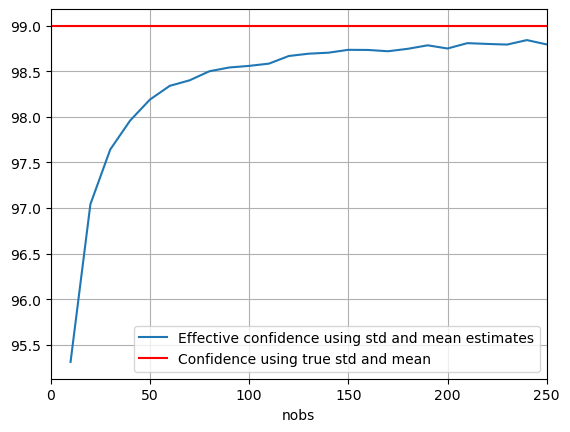

In [15]:
df.eff_confidence.plot( label = 'Effective confidence using std and mean estimates')
plt.grid()
plt.axhline((1-df.alpha.iloc[0])*100, c='r', label='Confidence using true std and mean')
plt.legend()
plt.xlim(0,250)

(0.0, 50.0)

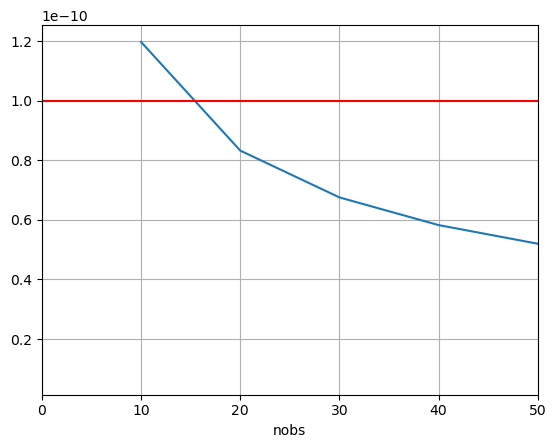

In [19]:
((df.xup-df.xlow)/2).plot(label = 'error on ReMS')
plt.axhline(df.std_.iloc[0]**2+df.mean_.iloc[0]**2*0.1,c='r', label = '10 % of ReMS')
plt.grid()
plt.xlim(0,50)

In [39]:
T = 400000
mean =1e-10
std = 2e-5 # typical std
alpha = 0.01
NOBS = np.arange(10, 150, 10)
Xup= []
Xlow=[]
P=[]
for Nobs in NOBS:
    xup, xlow, p = confidence_interval(Nobs, T, mean, std, alpha)
    Xup.append(xup)
    Xlow.append(xlow)
    P.append(p)
    print(Nobs)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


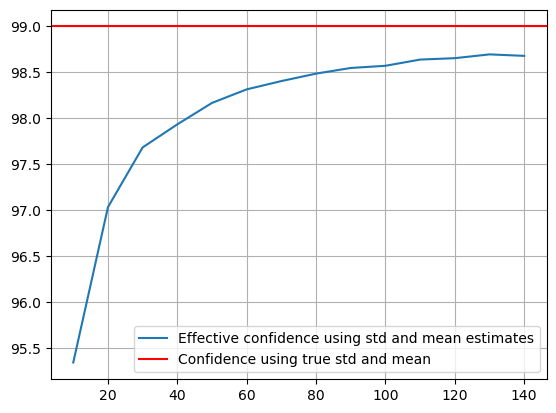

In [40]:
plt.plot(NOBS, P, label = 'Effective confidence using std and mean estimates')
plt.grid()
plt.axhline((1-alpha)*100, c='r', label='Confidence using true std and mean')
plt.legend()

<function matplotlib.pyplot.legend(*args, **kwargs)>

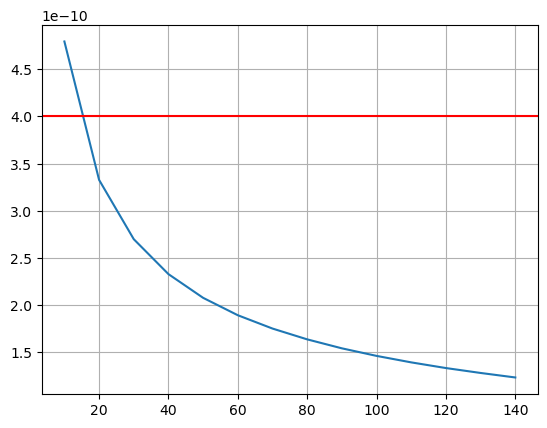

In [42]:
plt.plot(NOBS, (np.array(Xup)-np.array(Xlow))/2, label = 'error on MS')
plt.axhline(std**2+mean**2*0.1,c='r', label = '10 % of MS')
plt.grid()
plt.legend

___________
# Confidence of interval for $\langle x_i x_j \rangle $

$ C = x_ix_j$ follows a correlated central-normal distribution :  

$$ f_Z(z) = \frac{abs(z)}{1-\rho^2} \frac{1}{\pi \sqrt{1-\rho^2}} e^{\frac{\rho z}{1-\rho^2}} $$
with $\rho = \frac{\langle x_i x_j \rangle}{\sqrt{\langle x_i^2\rangle \langle x_j^2 \rangle}}$ and variance $\sigma^2 = 1+\rho^2$


The central limiot theorem then give that: $Z_k=\frac{\Sigma C -\Sigma \rho}{\Sigma \sigma^2}$ follows a standard normal law and thus :
$$Q_5(1+\rho^2)+\mu < \langle x_i x_j \rangle <Q_{95}(1+\rho^2)+\mu$$

In [ ]:
def compute_contribution_errors(ms12, ms1, ms2, alpha):
    import scipy.stats as sps
    rho = ms12/np.sqrt(ms1*ms2)
    dist = sps.norm(loc=0, scale=1)
    q5 = dist.ppf(alpha)
    return ms12 + q5*(1+rho**2), ms12 - q5*(1+rho**2)



In [7]:


y = xr.DataArray(np.random.normal(0.5, 0.3, (Nobs,T)),
                 dims=["Nobs", "T"],
                 coords=dict(Nobs=(["Nobs"], np.arange(Nobs)),T=(['T'], np.arange(T))))

In [8]:
xy = x*y

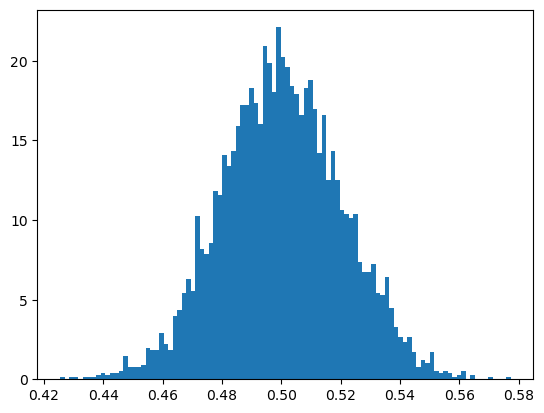

In [9]:
a = xy.mean(dim='Nobs').plot.hist(bins =100,density=True)